# Self-Organising Maps

In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

from our_som1A import SOM

In [33]:
# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [34]:
data.shape

(105, 6)

In [35]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [36]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
17,187820,134950,719
34,116290,971680,8356
18,186720,124931,669
89,13000,16000,1231
50,6660,6020,904
59,3813,3763,987
76,48800,1762580,36118
16,188455,132331,702
56,4422,3911,884
6,156310,92140,589


In [37]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
17,0.986299,0.056795,0.017878
34,0.610674,0.408939,0.207773
18,0.980523,0.052578,0.016635
89,0.068267,0.006734,0.030609
50,0.034974,0.002534,0.022478
59,0.020023,0.001584,0.024542
76,0.256263,0.741794,0.898078
16,0.989634,0.055692,0.017455
56,0.023221,0.001646,0.021981
6,0.820831,0.038778,0.014646


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

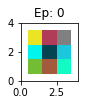

In [38]:
# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [39]:
def predict(df, agri_som):
    """
    finds the Best Matching Unit for each data sample.
    Thus, the neuron with closest distance from data sample.
    
    Args:
        df (pd.DataFrame): df to be updated
        agri_som (obj): model

    Returns:
        pd.DataFrame: updated df
    """
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [40]:
def arrange_data(agri_som):
    """
    Fetch BMU of data samples and append them to the filtered agri_dataset    

    Args:
        agri_som (object): SOM model

    Returns:
        pd.DataFrame: updated agri_data with BMU
    """
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [41]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Prospers Comment:
        with this implementation, the computation of the total_correct includes classes located in multiple clusters. 
        For instance, if POTATO is located in [0,0] with count of 20, and also located in [2,2] with count of 40, both instances are 
        included in the computation of the total_correct. But with the definition, POTATO will be assigned to the cluster [2,2] and 
        not [0,0] also, so computation will include only 40 for 'POTATO'. Kindly verify that.
        For this reason, I implemented a proposed edition tagged 'prospers_purity' correcting this error.

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """
    classes = [str(i) for i in df.bmu_idx.tolist()]  # all neurons/clusters responsible each data point
    classes_uniq = set(classes)  # unique neurons (<= 9 since 3*3 grid. less if some neuron(s) dont have any samples)
    clusters = {i:{} for i in classes_uniq}  # build associative array to hold all samples for each neuron.

    data = [[str(i),j] for i,j in zip(df.bmu_idx.tolist(), df.Crop)]
    for i in classes_uniq:
        for j in data:
            exact= j[0]
            pred = j[1]
            if exact == i:
                if pred not in clusters[exact].keys():
                    clusters[exact][pred] = 1
                else:
                    clusters[exact][pred] += 1
    total_correct = 0
    total = len(data)
    for cluster in clusters.values():
        total_correct += max(cluster.values())
    
    return total_correct/total

In [42]:
def visualize(joined_df, lr, lf,agri_som):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("learning function: "+lf+", learning rate: "+str(lr))

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()

In [43]:
"""
executes SOM for epochs [5, 10, 20, 30, 40, 50]
"""

external_purities_5 = []
def run_5(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 5 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train(trunc_data.values,
          num_epochs=5,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_5.append(external_purity(joined_df))


external_purities_10 = []
def run_10(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=10,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_10.append(external_purity(joined_df))

external_purities_20 = []
def run_20(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 20 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train(trunc_data.values,
          num_epochs=20,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_20.append(external_purity(joined_df))


external_purities_30 = []
def run_30(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 30 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train(trunc_data.values,
          num_epochs=30,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_30.append(external_purity(joined_df))


external_purities_40 = []
def run_40(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 40 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train(trunc_data.values,
          num_epochs=40,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_40.append(external_purity(joined_df))


external_purities_50 = []
def run_50(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 50 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train(trunc_data.values,
          num_epochs=50,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_50.append(external_purity(joined_df))


In [44]:
# More rates, and decay functions can be appended. cost is running time
lrs = [1, 0.1, 0.01, 0.001]  # base learning rates
lfs = ["default", "linear", "inverse", "power"]  # learning rate decay functions

# 16 runs/combinations in all
mesh = np.array(np.meshgrid(lrs, lfs))
lrs_lfs = mesh.T.reshape(-1, 2)

# agri_som = SOM(3,3,3)  # initialization
# weights = agri_som.net
weights = np.array(
	[
		[
			[0.04039447, 0.6495641 , 0.46165352],
			[0.9118578 , 0.28238622, 0.39812322],
			[0.58684143, 0.11878689, 0.99220547]
		],
       [
			[0.46852085, 0.94825253, 0.61640755],
			[0.80456765, 0.03104591, 0.45691878],
			[0.29590234, 0.77207143, 0.81684638]
		],
       [
			[0.96509498, 0.26071734, 0.78689664],
			[0.12195003, 0.47102914, 0.92465288],
			[0.81227374, 0.46423983, 0.98292867]
		]
	]
)

In [45]:
# # main runs
# for lr, lf in lrs_lfs:
#     lr = lr.astype('float64')
#     run_5(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
#     run_10(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
#     run_20(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
#     run_30(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
#     run_40(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
#     run_50(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)

#     print(f'lr:{lr}, lrf:{lf} done!')

### **Analyzing Results**

In [46]:
# # extract columns
# lrs_ = [_[0] for _ in lrs_lfs]
# lfs_ = [_[1] for _ in lrs_lfs]

# data = {
# 	'learning_function': lfs_,
# 	'learning_rate': lrs_,
# 	'external_purities_5': external_purities_5, 
# 	'external_purities_10': external_purities_10, 
# 	'external_purities_20': external_purities_20,
# 	'external_purities_30': external_purities_30, 
# 	'external_purities_40': external_purities_40, 
# 	'external_purities_50': external_purities_50,
# }
# results_df = pd.DataFrame(
# 	data, index=range(1, len(lrs_)+1)
# )

# results_df.head()

In [47]:
# # Descriptive statistics
# results_df.describe()

In [48]:
# # Highest Accuracies
# """
# Maximum Accuracy:
# 	- inverse learning function (1.0, 0.1) learning rates at 500 epochs 93%
# 	- default function, 1.0 learning rate. 10 epochs, 89%.
# 	- power function, 0.001 learning rate, 400 epochs, 89%/.

# """
# maxs = results_df.iloc[:,2:].idxmax().reset_index()
# maxs.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
# max_rows = maxs['row'].values

# # maximum rows for each epochs.
# results_df[results_df.index.isin(max_rows)]

In [49]:
# results_df

In [50]:
# # Minimum
# """
# Minimum Accuracy:
# 	- inverse function, 1.0 learning rate, 100 epochs, 66%.
# """
# mins = results_df.iloc[:,2:].idxmin().reset_index()
# mins.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
# min_rows = mins['row'].values

# # table of maximums by inspection from description, our best shot is row 12
# results_df[results_df.index.isin(min_rows)]

### **Individual Performance**

In [51]:
# # default
# """
# - overall accuracy decreases with smaller learning rates.
# - performance increases for larger epochs

# """
# results_df[results_df['learning_function'] == 'default']

In [52]:
# # linear
# """
# - overall accuracy decreases for smaller learning rates.
# - accuracy decreases for larger epochs.
# - not a good function.
# """
# results_df[results_df['learning_function'] == 'linear']

In [53]:
# # inverse
# """
# - overall accuracy increases for smaller learning rates but not for very very small rates (0.001)
# - accuracy increases across larger epochs.
# - a good function.
# """
# results_df[results_df['learning_function'] == 'inverse']

In [54]:
# # power
# """
# - overall accuracy decreases for smaller learning rates.
# - accuracy increases across larger epochs.
# - not a good function.
# """
# results_df[results_df['learning_function'] == 'power']

### **Runge-Kutta**

In [55]:
"""
executes SOM for epochs [5, 10, 20, 30, 40, 50]
"""

external_purities_5 = []
def run_5(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 5 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train_runge_kutta(trunc_data.values,
          num_epochs=5,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_5.append(external_purity(joined_df))


external_purities_10 = []
def run_10(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train_runge_kutta(trunc_data.values,
          num_epochs=10,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_10.append(external_purity(joined_df))

external_purities_20 = []
def run_20(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 20 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train_runge_kutta(trunc_data.values,
          num_epochs=20,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_20.append(external_purity(joined_df))


external_purities_30 = []
def run_30(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 30 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train_runge_kutta(trunc_data.values,
          num_epochs=30,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_30.append(external_purity(joined_df))


external_purities_40 = []
def run_40(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 40 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train_runge_kutta(trunc_data.values,
          num_epochs=40,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_40.append(external_purity(joined_df))


external_purities_50 = []
def run_50(weights, base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 50 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights = weights

    agri_som.train_runge_kutta(trunc_data.values,
          num_epochs=50,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_50.append(external_purity(joined_df))


In [56]:

for lr, lf in lrs_lfs:
    lr = lr.astype('float64')
    run_5(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_10(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_20(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_30(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_40(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_50(weights, base_lr=lr, lr_decay_function=lf, show_plot=False)

    print(f'lr:{lr}, lrf:{lf} done!')

lr:1.0, lrf:default done!
lr:1.0, lrf:linear done!
lr:1.0, lrf:inverse done!
lr:1.0, lrf:power done!
lr:0.1, lrf:default done!
lr:0.1, lrf:linear done!
lr:0.1, lrf:inverse done!
lr:0.1, lrf:power done!
lr:0.01, lrf:default done!
lr:0.01, lrf:linear done!
lr:0.01, lrf:inverse done!
lr:0.01, lrf:power done!
lr:0.001, lrf:default done!
lr:0.001, lrf:linear done!
lr:0.001, lrf:inverse done!
lr:0.001, lrf:power done!


**Results**

In [57]:
# extract columns
lrs_ = [_[0] for _ in lrs_lfs]
lfs_ = [_[1] for _ in lrs_lfs]

data = {
	'learning_function': lfs_,
	'learning_rate': lrs_,
	'external_purities_5': external_purities_5, 
	'external_purities_10': external_purities_10,
	'external_purities_20': external_purities_20,
	'external_purities_30': external_purities_30, 
	'external_purities_40': external_purities_40, 
	'external_purities_50': external_purities_50,
}
results_df_runge = pd.DataFrame(
	data, index=range(1, len(lrs_)+1)
)

results_df_runge.head()

,learning_function,learning_rate,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
1,default,1.0,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
2,linear,1.0,0.676190,0.666667,0.695238,0.714286,0.638095,0.647619
3,inverse,1.0,0.600000,0.714286,0.619048,0.685714,0.695238,0.742857
4,power,1.0,0.647619,0.685714,0.590476,0.676190,0.628571,0.523810
5,default,0.1,0.571429,0.590476,0.628571,0.695238,0.580952,0.657143


In [58]:
# Descriptive statistics
results_df_runge.describe()

,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.616071,0.607143,0.596429,0.621429,0.601190,0.608333
std,0.120102,0.129678,0.112519,0.121393,0.123191,0.119149
min,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,0.597619,0.597619,0.597619,0.609524,0.607143,0.607143
50%,0.633333,0.619048,0.609524,0.638095,0.619048,0.628571
75%,0.676190,0.688095,0.628571,0.688095,0.661905,0.650000
max,0.733333,0.761905,0.714286,0.714286,0.714286,0.742857


In [59]:
# default
results_df_runge[results_df_runge['learning_function'] == 'default']

,learning_function,learning_rate,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
1,default,1.0,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
5,default,0.1,0.571429,0.590476,0.628571,0.695238,0.580952,0.657143
9,default,0.01,0.685714,0.609524,0.609524,0.695238,0.695238,0.695238
13,default,0.001,0.666667,0.761905,0.714286,0.619048,0.676190,0.685714


In [60]:
# linear
results_df_runge[results_df_runge['learning_function'] == 'linear']

,learning_function,learning_rate,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
2,linear,1.0,0.676190,0.666667,0.695238,0.714286,0.638095,0.647619
6,linear,0.1,0.638095,0.600000,0.600000,0.609524,0.600000,0.600000
10,linear,0.01,0.590476,0.695238,0.590476,0.609524,0.619048,0.600000
14,linear,0.001,0.590476,0.561905,0.657143,0.657143,0.619048,0.638095


In [61]:
# inverse
results_df_runge[results_df_runge['learning_function'] == 'inverse']

,learning_function,learning_rate,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
3,inverse,1.0,0.600000,0.714286,0.619048,0.685714,0.695238,0.742857
7,inverse,0.1,0.619048,0.628571,0.609524,0.619048,0.619048,0.609524
11,inverse,0.01,0.714286,0.609524,0.609524,0.609524,0.619048,0.619048
15,inverse,0.001,0.733333,0.457143,0.561905,0.704762,0.447619,0.647619


In [62]:
# power
results_df_runge[results_df_runge['learning_function'] == 'power']

,learning_function,learning_rate,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
4,power,1.0,0.647619,0.685714,0.590476,0.676190,0.628571,0.523810
8,power,0.1,0.676190,0.695238,0.628571,0.685714,0.657143,0.628571
12,power,0.01,0.619048,0.628571,0.600000,0.600000,0.609524,0.609524
16,power,0.001,0.628571,0.609524,0.628571,0.561905,0.714286,0.628571
